### Convert SDO/AIA data from level 1 to level 1.5

AIA data products provides by the JSOC are level 1 data products.  
This means that the images still include the roll angle of the satellite and each channel may have a slightly different pixel scale.  
Typically, before performing any sort of data analysis on AIA images, you will want to promote your AIA data from level 1 to level 1.5.

1. Pointing correction (aiapy.calibrate.update_pointing)  
2. Image respiking (aiapy.calibrate.respike)  
3. PSF deconvolution (aiapy.psf.deconvolve)  
4. Registration (aiapy.calibrate.register)  
5. Degradation correction (aiapy.calibrate.correct_degradation)  
6. Exposure normalization

In this code, we only use method 1, 4, 5, and 6.

Reference.
https://aiapy.readthedocs.io/en/stable/preparing_data.html

In [1]:
import copy
import warnings

import numpy as np

import astropy.units as u

import sunpy
from sunpy.map import contains_full_disk

import aiapy
from aiapy.calibrate.util import get_pointing_table
from aiapy.calibrate.util import get_correction_table
from aiapy.util.exceptions import AIApyUserWarning

__all__ = ["update_pointing"]

In [2]:
fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2012\aia.lev1_euv_12s.2012-01-01T000009Z.193.image_lev1.fits"
aia_map = sunpy.map.Map(fits_file)
type(aia_map)

sunpy.map.sources.sdo.AIAMap

#### 1. Pointing correction

aiapy.calibrate.update_pointing(smap, *, pointing_table)

pointing_table = ``get_pointing_table``  
: This method removes any ``PCi_j`` matrix keys in the header and updates the ``CROTA2`` keyword.

In [3]:
pointing_tbl = get_pointing_table(
    "JSOC",
    time_range=(aia_map.date - 6*u.hour, aia_map.date + 6*u.hour)
)

aia_map_pt = aiapy.calibrate.update_pointing(aia_map, pointing_table=pointing_tbl)

In [4]:
# To check a change.
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2","CROTA2"]:
    print(key, "before:", aia_map.meta[key], "after:", aia_map_pt.meta[key])


CRPIX1 before: 2043.09998 after: 2043.348511
CRPIX2 before: 2042.29004 after: 2041.547485
CDELT1 before: 0.600758016 after: 0.600714
CDELT2 before: 0.600758016 after: 0.600714
CROTA2 before: 0.0564525016 after: 0.0578085015073


#### 2. Registration

In [5]:
aia_map_reg = aiapy.calibrate.register(
    aia_map_pt,
    missing=np.nan,     # extrapolation: fill with NaN
    order=3,            # interpolation: bicubic        
    method='scipy'      # Rotation function to use: scipy
)

In [6]:
# To check a change.
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2"]:
    print(key, "before:", aia_map_pt.meta[key], "after:", aia_map_reg.meta[key])

CRPIX1 before: 2043.348511 after: 2048.5
CRPIX2 before: 2041.547485 after: 2048.5
CDELT1 before: 0.600714 after: 0.6
CDELT2 before: 0.600714 after: 0.6


#### 3. Degradation correction

In [7]:
corr_tbl = get_correction_table("SSW")

aia_map_cal = aiapy.calibrate.correct_degradation(
    aia_map_reg,
    correction_table=corr_tbl
)

In [8]:
print("before:", aia_map_reg.date.isot, " after:", aia_map_cal.date.isot)

before: 2012-01-01T00:00:07.838  after: 2012-01-01T00:00:07.838


#### 4. Exposure normalization

In [9]:
exp_time = aia_map_cal.exposure_time

aia_map_norm = aia_map_cal / exp_time

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2012-01-01 00:00:07
Exposure Time,1.9996 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

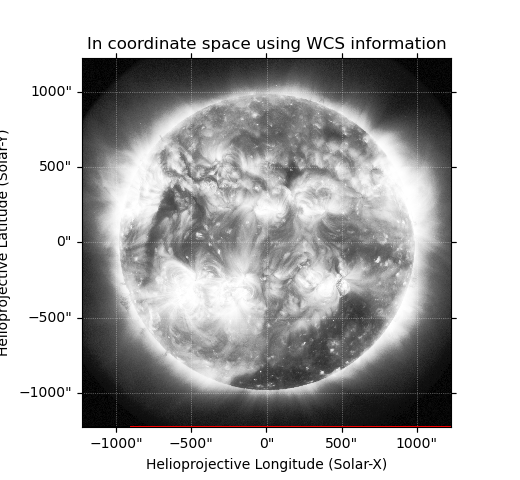
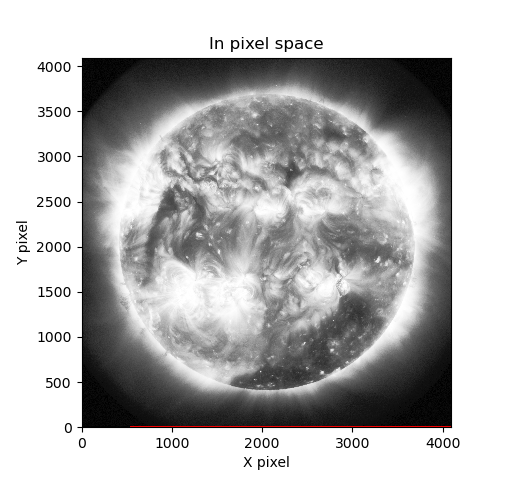
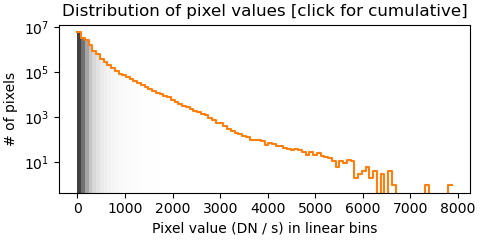
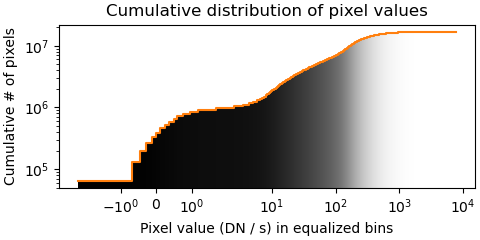

In [10]:
aia_map_norm